# Identifying potential diabetes patients

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# read the data and establish a quick baseline
df = pd.read_csv('diabetes.csv')
print(df.info())
baseline = df.Outcome.sum()/df.shape[0]
print('Baseline: {:.2f}'.format(baseline))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Baseline: 0.35


In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


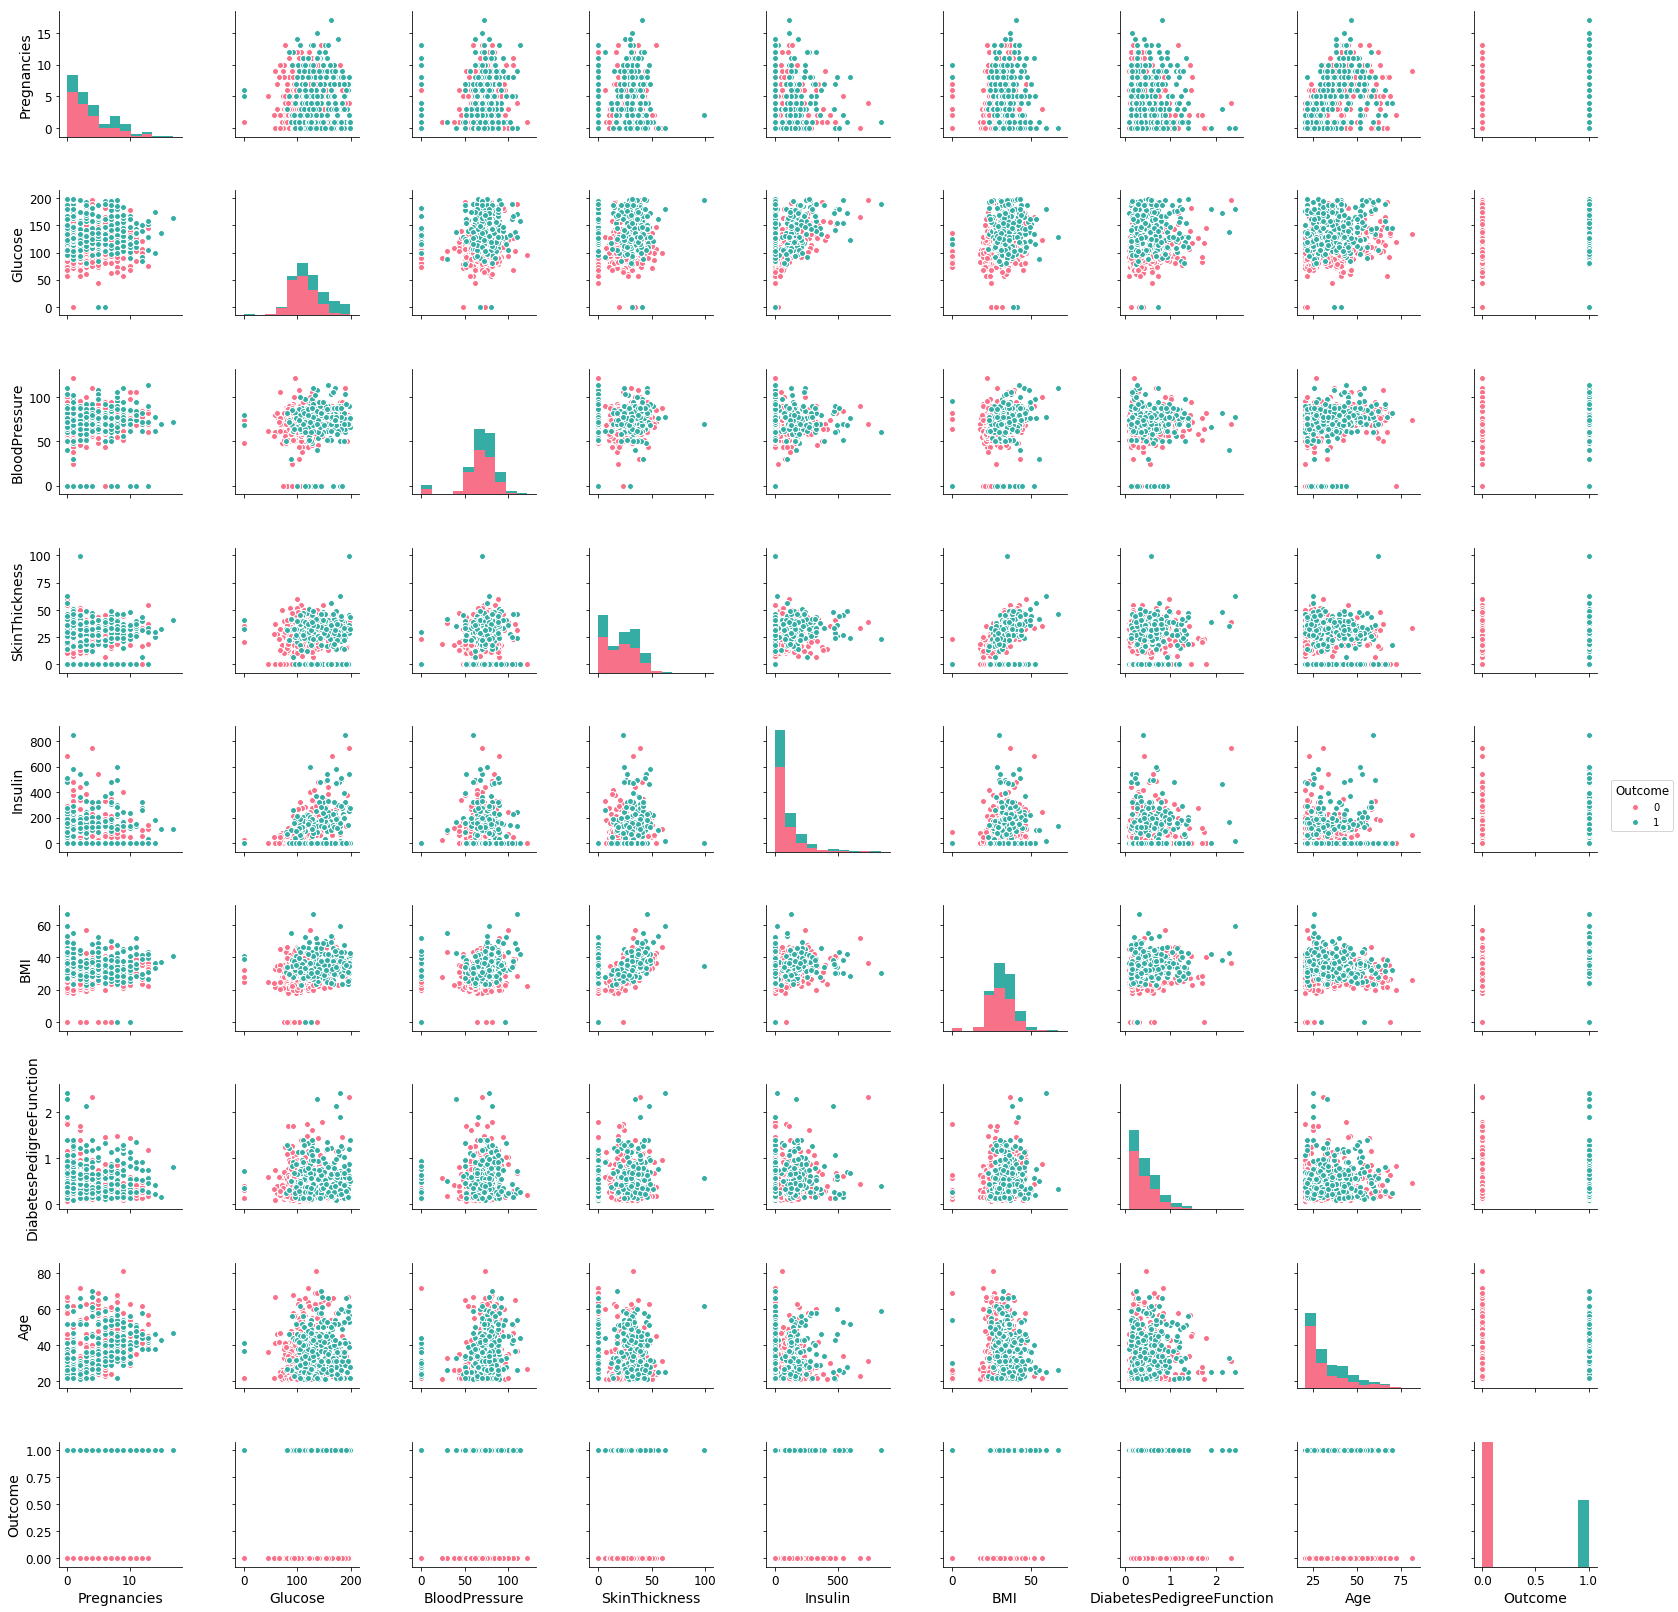

In [4]:
g = sns.pairplot(df, hue="Outcome", palette="husl")

Some of the factors like Glucose, insulin, Skin thickiness, BMI and Blood Pressure have value of zero. It is not possible to have a Blood pressure and BMI of zero. Most likely blank. There are also some outliers

A blood glucose level of less tha 40mg/dL might even stop brain function. 

In [5]:
# Creating a list of estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

1. Logictic regression is similar to linear regression, but the linear function is passed through a sigmoid function to get scores between 0 and 1.
2. Random forest classifier is an ensamble technique where multiple trees are generated based on random selection of features and data points. The goal is to minimize entropy which is a measure of uncertainty at any node
3. AdaBoostClassifier a forest of stumps. A stump is a tree where the prediction is done only on one feature. The misclassified data points are given more imporantance when the next stump is made. Finally, the prediciton is the combination of all stumps based on their weights which is measure of the stump's predictive power
4. GradientBoostingClassifier is slightly more complicated to explain. (watch Statquest)
5. KNN looks at the nearest neighbors to classify
6. SVC tries to find a boundary that best separates the data while maximizing the distance of the boundary separating the two classes.

In [6]:
# Creating a list of estimators
base_estimators = {
    'lr': LogisticRegression(max_iter=1000),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(),
    'svm': SVC(probability=True),
    'knn': KNeighborsClassifier(),
    'ab': AdaBoostClassifier(),
    'gbm': GradientBoostingClassifier()
}

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

In [8]:
# Splitting into X and y values
features = list(df.columns)
features.remove('Outcome')
X = df[features].values
y = df['Outcome'].values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = df.Outcome)

# Using training set to furthur divide it for cross validation
# DataFrame to collect results
base_result_df = pd.DataFrame(None, columns = ['name', 'accuracy', 'recall', 'precision'])

# Loop over the estimators to look at performance without any hyperparameter tuning
for estimator_name in base_estimators:
    estimator = base_estimators[estimator_name]
    accuracy = cross_val_score(estimator, X_train, y_train, cv = 5, scoring='accuracy')
    precision = cross_val_score(estimator, X_train, y_train, cv = 5, scoring='precision')
    recall = cross_val_score(estimator, X_train, y_train, cv = 5, scoring='recall')
    base_result_df = base_result_df.append({
                                'name':  estimator_name,
                                'accuracy': round(accuracy.mean(),2),
                                'precision': round(precision.mean(),2),
                                'recall': round(recall.mean(),2)
                            }, ignore_index=True)

In [9]:
# Just a quick look at the results
base_result_df

,name,accuracy,recall,precision
0,lr,0.78,0.57,0.74
1,dt,0.69,0.57,0.55
2,rf,0.76,0.56,0.70
3,svm,0.76,0.48,0.74
4,knn,0.74,0.54,0.66
5,ab,0.75,0.57,0.67
6,gbm,0.75,0.57,0.67


## Some data cleaning 

<b>Attribute Information:</b>
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

/home/user_dsi_vnc/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Count after cleaning')

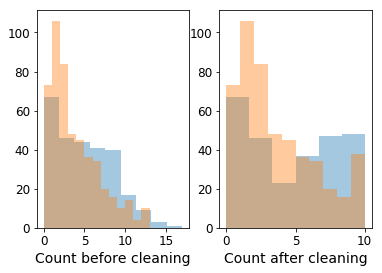

In [10]:
# Pregnanices
fig, axs = plt.subplots(ncols=2)
sns.distplot(df[df.Outcome==1].Pregnancies, kde=False, ax=axs[0])
sns.distplot(df[df.Outcome==0].Pregnancies, kde=False, ax=axs[0])
ax = axs[0]
ax.set_xlabel('Count before cleaning')

# For either of the classes. It seems a little farfected to have pregancies more than 12 times in a lifetime. 
# Lets cap this at 10. Any value above 10 is replaced with 10
df.loc[df.Pregnancies > 10, 'Pregnancies'] = 10
sns.distplot(df[df.Outcome==1].Pregnancies, kde=False, ax=axs[1])
sns.distplot(df[df.Outcome==0].Pregnancies, kde=False, ax=axs[1])
ax = axs[1]
ax.set_xlabel('Count after cleaning')

In [11]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

/home/user_dsi_vnc/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


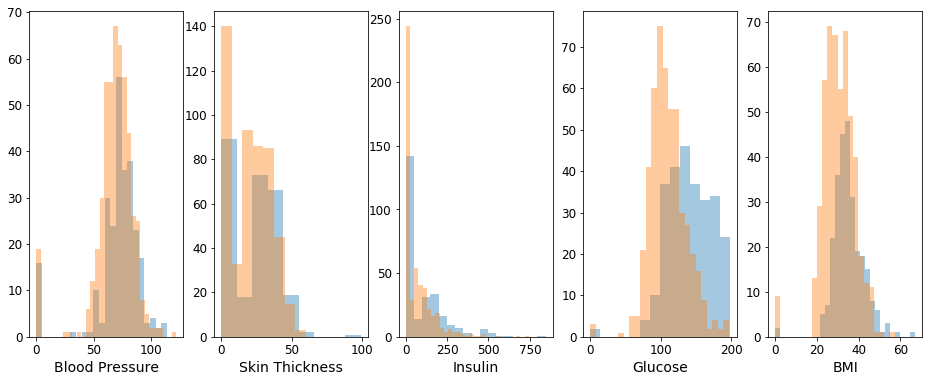

In [12]:
# Blood pressure
fig, axs = plt.subplots(ncols=5, figsize=(16,6))
def PlotHist(df, column_name, axes_label, axes_index, fig=fig, axs=axs):
    sns.distplot(df[df.Outcome==1][column_name], kde=False, ax=axs[axes_index])
    sns.distplot(df[df.Outcome==0][column_name], kde=False, ax=axs[axes_index])
    ax = axs[axes_index]
    ax.set_xlabel(axes_label)

PlotHist(df, 'BloodPressure', 'Blood Pressure', 0)
PlotHist(df, 'SkinThickness', 'Skin Thickness', 1)
PlotHist(df, 'Insulin', 'Insulin', 2)
PlotHist(df, 'Glucose', 'Glucose', 3)
PlotHist(df, 'BMI', 'BMI', 4)

# Clearly, a valyue of zero for a lot of these variables seem like a replacement for null, as blood pressure for
# anyone shouldn't be zero
# Let's use KNN imputation technique
def ReplaceWithNan(df, column_name):
    df.loc[df[column_name] == 0, column_name] = np.nan
    return df
df = ReplaceWithNan(df, 'BloodPressure')
df = ReplaceWithNan(df, 'SkinThickness')
df = ReplaceWithNan(df, 'Insulin')
df = ReplaceWithNan(df, 'Glucose')
df = ReplaceWithNan(df, 'BMI')
df.info()

In [13]:
# Lets try KNN imputation
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
knn_imputer = KNNImputer()
simple_imputer = SimpleImputer(strategy='median')
scalar = StandardScaler()

In [14]:
# Splitting into X and y values
features = list(df.columns)
features.remove('Outcome')
X = df[features].values
y = df['Outcome'].values

# Impute
X_knn = knn_imputer.fit_transform(X)
X_simple = simple_imputer.fit_transform(X)
X_knn = scalar.fit_transform(X_knn)
X_simple = scalar.fit_transform(X_simple)

# Test Train split
X_ki_train, X_ki_test, y_ki_train, y_ki_test = train_test_split(X_knn, y, test_size=0.2, stratify=df['Outcome'])
X_si_train, X_si_test, y_si_train, y_si_test = train_test_split(X_simple, y, test_size=0.2, stratify=df['Outcome'])

In [15]:
# Using training set to furthur divide it for cross validation
# DataFrame to collect results
result_ki_df = pd.DataFrame(None, columns = ['name', 'accuracy_ki', 'recall_ki', 'precision_ki'])

# Loop over the estimators to look at performance without any hyperparameter tuning
for estimator_name in base_estimators:
    estimator = base_estimators[estimator_name]
    accuracy = cross_val_score(estimator, X_ki_train, y_ki_train, cv = 5, scoring='accuracy')
    precision = cross_val_score(estimator, X_ki_train, y_ki_train, cv = 5, scoring='precision')
    recall = cross_val_score(estimator, X_ki_train, y_ki_train, cv = 5, scoring='recall')
    result_ki_df = result_ki_df.append({
                                'name':  estimator_name,
                                'accuracy_ki': round(accuracy.mean(),4),
                                'precision_ki': round(precision.mean(),4),
                                'recall_ki': round(recall.mean(),4)
                            }, ignore_index=True)

In [16]:
# Using training set to furthur divide it for cross validation
# DataFrame to collect results
result_si_df = pd.DataFrame(None, columns = ['name', 'accuracy_si', 'recall_si', 'precision_si'])

# Loop over the estimators to look at performance without any hyperparameter tuning
for estimator_name in base_estimators:
    estimator = base_estimators[estimator_name]
    accuracy = cross_val_score(estimator, X_si_train, y_si_train, cv = 5, scoring='accuracy')
    precision = cross_val_score(estimator, X_si_train, y_si_train, cv = 5, scoring='precision')
    recall = cross_val_score(estimator, X_si_train, y_si_train, cv = 5, scoring='recall')
    result_si_df = result_si_df.append({
                                'name':  estimator_name,
                                'accuracy_si': round(accuracy.mean(),4),
                                'precision_si': round(precision.mean(),4),
                                'recall_si': round(recall.mean(),4)
                            }, ignore_index=True)

In [17]:
result_df = base_result_df.merge(result_ki_df, on='name', how='inner')
result_df = result_df.merge(result_si_df, on='name', how='inner')

In [18]:
result_df

,name,accuracy,recall,precision,accuracy_ki,recall_ki,precision_ki,accuracy_si,recall_si,precision_si
0,lr,0.78,0.57,0.74,0.7524,0.5420,0.6809,0.7671,0.5374,0.7289
1,dt,0.69,0.57,0.55,0.6661,0.5464,0.5424,0.6906,0.5705,0.5733
2,rf,0.76,0.56,0.70,0.7394,0.5793,0.6496,0.7573,0.6074,0.6923
3,svm,0.76,0.48,0.74,0.7443,0.5377,0.6677,0.7443,0.4994,0.6847
4,knn,0.74,0.54,0.66,0.7345,0.6120,0.6192,0.7361,0.6165,0.6228
5,ab,0.75,0.57,0.67,0.7263,0.5698,0.6163,0.7557,0.5937,0.6701
6,gbm,0.75,0.57,0.67,0.7231,0.5980,0.6037,0.7589,0.6120,0.6628


## Let's try plotting learning curves

In [19]:
from sklearn.model_selection import learning_curve

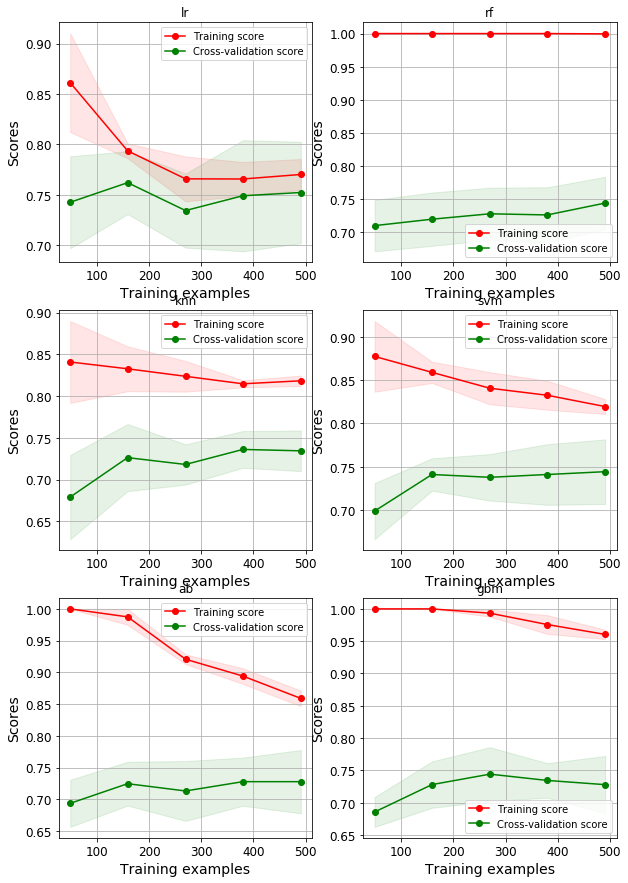

In [76]:
# Number of plots 
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Loop through your base estimators
x = 0
y = 0

def plot_learning_curves(estimator, name, X_train, y_train, x, y, axes=axes):
    
    # Get learning scores. You will get a score for each cv step
    train_sizes, train_scores, test_scores, fit_times, _  = \
                learning_curve(estimator, X_train, y_train, cv=5, return_times=True)
    
    # Take the average of your cross validation results
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)  
    
    # Assigning to one graph
    if isinstance(axes,np.ndarray):
        ax = axes[x,y]
    else: 
        ax = axes
    ax.grid()
    
    # plotting test and training scores and one std away
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Scores')
    ax.set_title(name)
    ax.legend(loc="best")
    
# Calling learning curve function ('lr', 'dt', 'rf', 'svm', 'knn', 'ab', 'gbm')
X = X_ki_train
y = y_ki_train
plot_learning_curves(base_estimators['lr'], 'lr', X, y, 0 ,0)
plot_learning_curves(base_estimators['rf'], 'rf', X, y, 0 ,1)
plot_learning_curves(base_estimators['knn'], 'knn', X, y, 1 ,0)
plot_learning_curves(base_estimators['svm'], 'svm', X, y, 1 ,1)
plot_learning_curves(base_estimators['ab'], 'ab', X, y, 2 ,0)
plot_learning_curves(base_estimators['gbm'], 'gbm', X, y, 2 ,1)



Learning curves help you check for overfitting and bias. For example, with the Random forest algorithm without any 
hyperparameter tuning, it will overfit. This is evident from the graph.

## Let's build an example of hyper parameter tuning and check to see if things improve

In [45]:
# We will use only Random forest as an example
RandomForestClassifier().get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

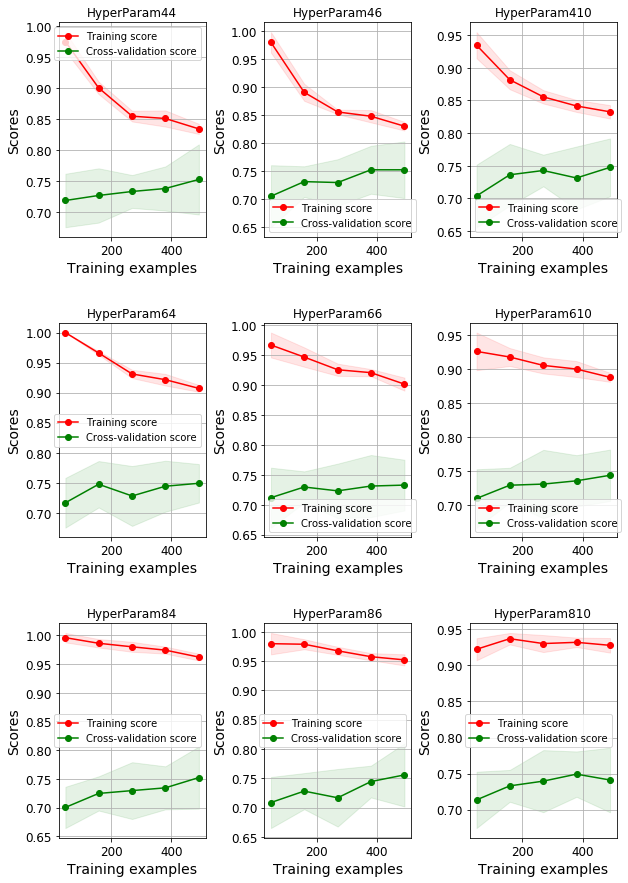

In [50]:
# Lets play with a couple of hypterparameters to start with
# Number of plots 
fig, axes = plt.subplots(3, 3, figsize=(10, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
X = X_ki_train
y = y_ki_train
max_depth = [4,6,8]
min_samples_split = [4,6,10]
plot_x = 0
plot_y = 0
for i in range(len(max_depth)):
    for j in range(len(min_samples_split)):
        estimator = RandomForestClassifier(n_estimators=50, 
                                           max_depth=max_depth[i], 
                                           min_samples_split=min_samples_split[j])
        plot_learning_curves(estimator, 'HyperParam'+str(max_depth[i])+str(min_samples_split[j]), X, y, plot_x, plot_y, axes)
        plot_y += 1
    plot_x += 1
    plot_y = 0

# This is one way of hyperparameter tuning. This however reduces overfitting but doesn't seem to be improving 
# cross validation scores. This is however the concept to reduce overfitting. We can use GridSearchCV or RandomSearch

In [51]:
# Grid Search based hyper parameter tuning
from sklearn.model_selection import GridSearchCV

In [61]:
# Hyper Parameters
parameters = {'max_depth' : [4,6,8], 
              'min_samples_split' : [4,6,10],
              'n_estimators': [20,50,100],
              'max_features' :[2,4,6]}

estimator = GridSearchCV(RandomForestClassifier(), param_grid = parameters, cv=3, error_score='recall')
estimator = estimator.fit(X_train, y_train) # Fit estimator
estimator.best_params_ # Get best params

{'max_depth': 6,
 'max_features': 6,
 'min_samples_split': 10,
 'n_estimators': 20}

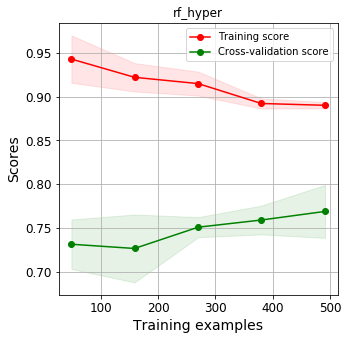

In [85]:
# Let's try plotting learning curve for this set of hyperparamters
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X_train = scalar.fit_transform(X_train)
estimator = RandomForestClassifier(n_estimators=20, max_features=6, min_samples_split=10, max_depth=6)
plot_learning_curves(estimator, 'rf_hyper', X_train, y_train, 0, 0, axes = axes)

# There is still some scope to remove overfitting. But an important thing to notice is an importment in score
# with hyperparamter tuning.Note: The plot is for accuracy, but the GridSearch was to maximize recall

## Now let's try building a voting based model

In [87]:
from sklearn.ensemble import VotingClassifier

In [131]:
lr_estimator = LogisticRegression(max_iter=1000)
rf_estimator = RandomForestClassifier(n_estimators=20, max_features=6, min_samples_split=10, max_depth=6)
knn_estimator = KNeighborsClassifier(n_neighbors=7)
svc_estimator = SVC()
xgb_estimator = XGBClassifier(learning_rate=0.05, n_estimators=200, max_depth=2)
ab_estimator = AdaBoostClassifier(n_estimators=30)
gbm_estimator = GradientBoostingClassifier(n_estimators=50,  min_samples_split=10, max_features=4)

In [132]:
voting_classiifer = VotingClassifier(estimators=[('lr', lr_estimator), 
                                                 ('rf', rf_estimator), 
                                                 ('knn', knn_estimator),
                                                 ('xgb', xgb_estimator)
                                                ], voting='hard')

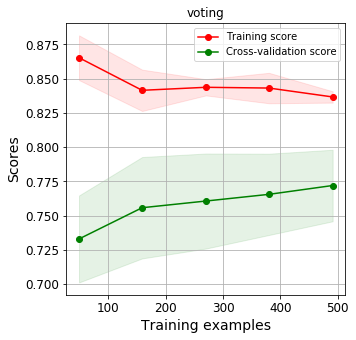

In [133]:
# Let's try plotting learning curve for this set of hyperparamters
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plot_learning_curves(voting_classiifer, 'voting', X_train, y_train, 0, 0, axes = axes)

In [92]:
# As you can see the Voting classifier already does better than individual classifiers

## Xgboost

In [145]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, auc, precision_recall_curve, roc_curve

In [119]:
# Create the estimtor and fit the data
estimator = XGBClassifier(learning_rate=0.05, n_estimators=200, max_depth=2)
estimator = estimator.fit(X_train, y_train)

# Predict values
y_pred = estimator.predict(X_train)

# Another way to look at error is: Classification report, confusion matrix, auc etc.
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       400
           1       0.80      0.66      0.72       214

    accuracy                           0.82       614
   macro avg       0.82      0.79      0.80       614
weighted avg       0.82      0.82      0.82       614



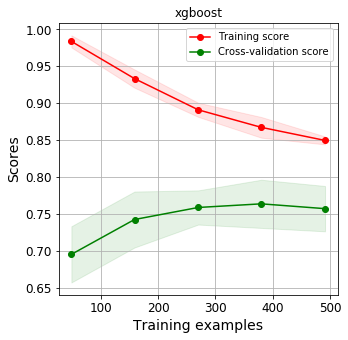

In [120]:
# Let's try plotting learning curve for this set of hyperparamters
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plot_learning_curves(estimator, 'xgboost', X_train, y_train, 0, 0, axes = axes)

In [157]:
# Another metric to look at is Auc curve
y_proba = estimator.predict_proba(X_train)[:,1]
fpr, tpr, _ = roc_curve(y_train, y_proba)
roc_auc= auc(fpr, tpr)
print(roc_auc)

0.9203796728971964


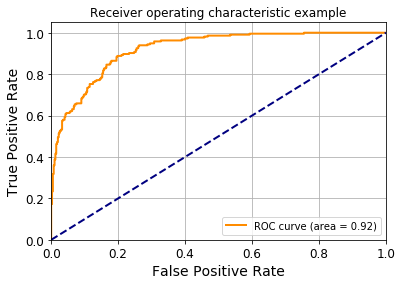

In [158]:
# Plotting Auc
lw = 2
plt.grid()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Let try super learners

In [160]:
from mlens.ensemble import SuperLearner

In [165]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=6,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.001, 
    random_state=42
)

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=42,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_estimators.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
p_sl = sl.predict_proba(X_train)


Fitting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:01
Fit complete                        | 00:00:05

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01


In [166]:
pp = []
for p in p_sl[:, 1]:
    if p>0.5:
        pp.append(1.)
    else:
        pp.append(0.)

In [168]:
print("\nSuper Learner Accuracy score: %.8f" % (y_train== pp).mean())


Super Learner Accuracy score: 0.80456026
